In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import re
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from collections import Counter

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine, euclidean
from sklearn.manifold import MDS, Isomap

from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint

# Materials Project related
#from pymatgen.ext.matproj import MPRester
from mp_api.client import MPRester

## 1. Prepare the data

In [6]:
# read the data
with open('data.json') as f:
    data = json.load(f)

In [3]:
# convert to dataframe
df = pd.DataFrame(data)
df['icsd_id'] = df['icsd_id'].astype('int')
df = df.set_index('icsd_id')

In [ ]:
# convert cif to pymatgen structures for following processing
structs = []
for d in data:
    struct = Structure.from_str(d['cif'], fmt='cif') # 使用pymatgen的Structure.from_str()方法从CIF字符串创建结构对象
    structs.append(struct)

df['structure'] = structs

## 2. Get distance matrix

This part is optional, all the representations and distance matrix are pre-calculated

### 2.1 Convert compositions to the Peroidic Table representation

In [114]:
# periodic table representation, ptr
ptr = [
    ['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '','', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
    ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
    ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
    ['K', 'Ca', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
    ['Rb', 'Sr', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe'],
    ['Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn'],
    ['Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
]

In [115]:
pd.DataFrame(ptr)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,H,,,,,,,,,,...,,,,,,,,,,He
1,Li,Be,,,,,,,,,...,,,,,B,C,N,O,F,Ne
2,Na,Mg,,,,,,,,,...,,,,,Al,Si,P,S,Cl,Ar
3,K,Ca,,,,,,,,,...,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr
4,Rb,Sr,,,,,,,,,...,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe
5,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
6,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,...,Mt,Ds,Rg,Cn,Nh,Fl,Mc,Lv,Ts,Og


In [116]:
dim_1, dim_2 = 7, 32

In [117]:
PTRs = []
for idx in df.index:
    struct = df.loc[idx, 'structure']
    comp = Composition(struct.formula)
    comp_dict = comp.fractional_composition.as_dict()
    
    np_ptr = np.zeros((dim_1, dim_2))
    
    # Update the periodic table array with values from the dictionary
    for i, row in enumerate(ptr):
        for j, element in enumerate(row):
            if element in comp_dict:
                np_ptr[i][j] = comp_dict[element]

    PTRs.append(np_ptr)

df['PTR'] = PTRs

### 2.2 Compositional similarity using Wasserstein distance

In [ ]:
# calculate EMD using OpenCV siganiture 

sigs = []
for d in data:
    sig = np.zeros((dim_1 * dim_2, 3)).astype("float32")
    for h in range(dim_1):
        for s in range(dim_2):
            idx = dim_2 * h + s
            sig[idx][0] = d['PTR'][h][s]
            sig[idx][1], sig[idx][2] = h, s
    sigs.append(sig)

df_comp = pd.DataFrame(np.zeros((len(data), len(data))))
for i, sig_1 in enumerate(sigs):
    for j, sig_2 in enumerate(sigs):
        if i <= j:
            df_comp[i][j] = np.round(cv2.EMD(sig_1, sig_2, cv2.DIST_L2)[0],3)
            df_comp[j][i] = df_comp[i][j]

df_comp.index = df.index
df_comp.columns = df.index
df_comp.to_csv('distance_matrix_PTR.csv')

### 2.3 Compositional similarity using cosine and Euclidean distances 


In [ ]:
# Extracting signatures from data
sigs = []
for d in data:
    sig = [d['PTR'][h][s] for h in range(dim_1) for s in range(dim_2)]
    sigs.append(np.array(sig))

# Initializing DataFrames to store the distance matrices
df_cosine = pd.DataFrame(np.zeros((len(sigs), len(sigs))), index=df.index, columns=df.index)
df_euclidean = pd.DataFrame(np.zeros((len(sigs), len(sigs))), index=df.index, columns=df.index)

# Calculating pairwise cosine and Euclidean distances
for i, sig_1 in enumerate(sigs):
    for j in range(i, len(sigs)):  # Only fill upper triangle, matrix is symmetric
        sig_2 = sigs[j]
        cos_dist = cosine(sig_1, sig_2)
        euc_dist = euclidean(sig_1, sig_2)

        # Filling symmetric matrix for both cosine and Euclidean distances
        df_cosine.loc[df.index[i], df.index[j]] = df_cosine.loc[df.index[j], df.index[i]] = np.round(cos_dist, 3)
        df_euclidean.loc[df.index[i], df.index[j]] = df_euclidean.loc[df.index[j], df.index[i]] = np.round(euc_dist, 3)

# Saving distance matrices to CSV files
df_cosine.to_csv('cosine_distance_matrix.csv')
df_euclidean.to_csv('euclidean_distance_matrix.csv')

### 2.4 calcualate gemoetrical similarity using LoStOP

In [120]:
# Local structure order parameters 
ssf = SiteStatsFingerprint(
    CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0), 
    stats=('mean','std_dev','minimum','maximum')
)

In [121]:
len(ssf.featurize(struct))

244

In [ ]:
st = time.time()
for i, d in enumerate(data):
    d['LoStOP'] = ssf.featurize(structs[i])
    if i % 50 == 0:
        print(i, int(time.time() - st))

In [ ]:
# calculate local enveriment similarity matrix
df_geom = pd.DataFrame(np.zeros((len(data), len(data))))

for i, d_1 in enumerate(data):
    for j, d_2 in enumerate(data):
        if i <= j:
            df_geom[i][j] = np.round(np.linalg.norm(np.array(d_1['LoStOP']) - np.array(d_2['LoStOP'])), 3)
            df_geom[j][i] = df_geom[i][j]

df_geom.index = df.index
df_geom.columns = df.index
df_geom.to_csv('distance_matrix_LoStOP.csv')

## 3. use DBSCAN to cluster the compounds

In [2]:
# read the pre-calculated distance matrix
PTR_dist = pd.read_csv('distance_matrix_PTR.csv', index_col=0)
cosine_dist = pd.read_csv('cosine_distance_matrix.csv', index_col=0)
euclidean_dist = pd.read_csv('euclidean_distance_matrix.csv', index_col=0)

LoStOP_dist = pd.read_csv('distance_matrix_LoStOP.csv', index_col=0)

In [3]:
clu_ptr = DBSCAN(eps=1, min_samples=3, metric='precomputed').fit(PTR_dist + LoStOP_dist)
clu_cosine = DBSCAN(eps=1, min_samples=3, metric='precomputed').fit(cosine_dist + LoStOP_dist) 
clu_euclidean = DBSCAN(eps=1, min_samples=3, metric='precomputed').fit(euclidean_dist + LoStOP_dist)

In [5]:
clu_compos = DBSCAN(eps=0.1, min_samples=3, metric='precomputed').fit(PTR_dist)
clu_nn = DBSCAN(eps=0.5, min_samples=3, metric='precomputed').fit(LoStOP_dist)

In [7]:
all_labels = pd.DataFrame(index=PTR_dist.index,
                          columns=['formula', 'PTR_label', 'LoStOP_label', 'Final PTR', 'Final cosine', 'Final Euclid'])

for i, d in enumerate(data):
    all_labels.loc[int(d['icsd_id'])] = [d['formula'],
                                         clu_compos.labels_[i],
                                         clu_nn.labels_[i],
                                         clu_ptr.labels_[i],
                                         clu_cosine.labels_[i],
                                         clu_euclidean.labels_[i],
                                        ] 

In [9]:
all_labels.to_csv('all_labels.csv')

## 4. Get DFT calculation results from Materials Project

In [ ]:
# Initialize the MPRester with your API key
api_key = "Your API Key"
m = MPRester(api_key)

In [ ]:
cols = ['icsd', 'material_id', 'formation_energy', 'band_gap', 'bulk_modulus']
df_icsd = pd.DataFrame(columns=cols)

results = {}
for icsd_id in df['icsd_id'].to_list():
    # Fetch data for each ICSD ID
    data = m.query(criteria={"icsd_ids": icsd_id}, properties=["material_id", "band_gap", 
                                                               "elasticity", "formation_energy_per_atom"])
    
    if data:
        entry = data[0]
        material_id = entry.get('material_id')
        band_gap = entry.get('band_gap')
        bulk_modulus = entry.get('elasticity', {}).get('K_VRH') if entry.get('elasticity') else np.nan
        formation_energy = entry.get('formation_energy_per_atom')
        
        df_icsd.loc[len(df_icsd)] = [icsd_id, material_id, formation_energy, band_gap, bulk_modulus]
    else:
        df_icsd.loc[len(df_icsd)] = [icsd_id, np.nan, np.nan, np.nan, np.nan]
                                     
    if len(df_icsd) % 100 == 0:
        time.sleep(1)
        print(len(df_icsd))
    

In [ ]:
all_labels = pd.concat([all_labels, df_icsd.reset_index(drop=True)], axis=1)

In [ ]:
all_labels.to_csv('all_labels.csv')

## 4. plot the results

### Figure S1

In [ ]:
all_labels = pd.read_csv('all_labels.csv', index_col=0)

In [ ]:
all_elem = []
for cf in all_labels['formula']:
    c = Composition(cf)
    all_elem.extend(c.elements)
    #break

all_elem_symbol = [ elem.symbol for elem in all_elem]

In [ ]:
# Count the frequency of each item in the list
item_counts = Counter(all_elem_symbol)
item_counts.pop('Cu')
item_counts.pop('S')

df_plot = pd.DataFrame(item_counts, index=['count']).transpose()
df_plot = df_plot.sort_values('count', ascending=False)

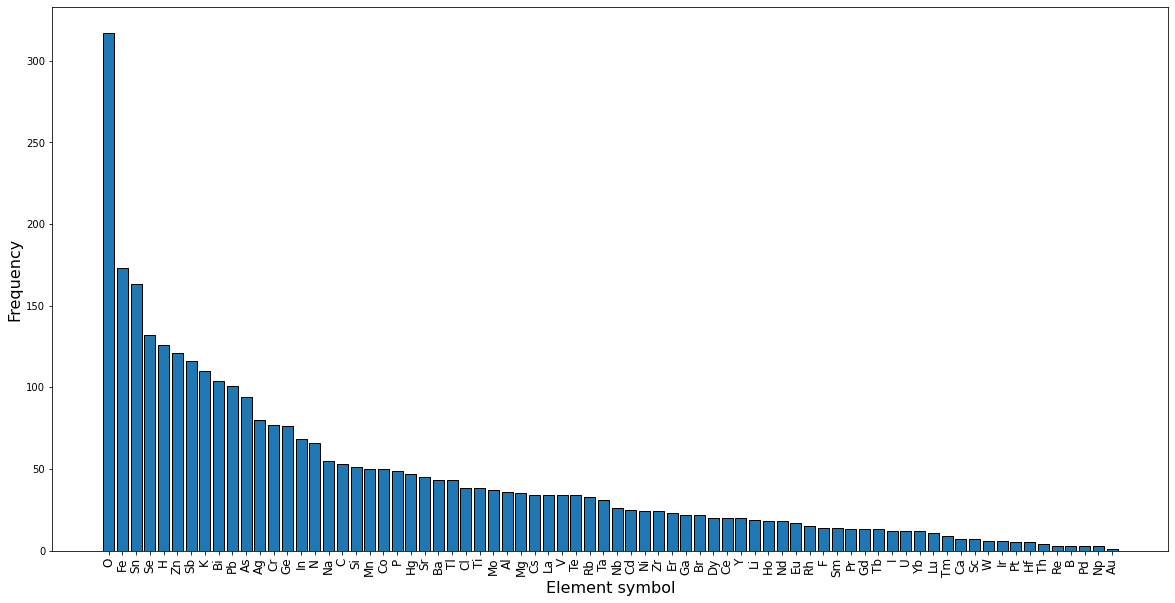

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

# Create the histogram
#plt.bar(item_counts.keys(), item_counts.values(), edgecolor='black')
plt.bar(df_plot.index, df_plot['count'], edgecolor='black')

# Adding titles and labels
plt.xlabel('Element symbol', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90, fontsize=12)

# Show the plot
plt.show()

### Figure 2b

In [311]:
df_plot = all_labels[['formula','Final PTR']].copy()

In [312]:
groups = {
    -1: ['No group','#17becf'], 
    0: ['Diamond like', '#1f77b4'], 
    6: ['Colusite-like', '#ff7f0e'], 
    23: ['Spinel', '#2ca02c'], 
    40: ['Tetrahedirte realted', '#d62728'], 
    41: ['Tetrahedirte realted', '#d62728'], 
    42: ['Tetrahedirte realted', '#d62728'], 
    43: ['Tetrahedirte realted', '#d62728'], 
    44: ['Tetrahedirte realted', '#d62728'], 
    55: ['Rare-earth intercalated', '#9467bd'], 
    61: ['Layered oxysulfides', '#8c564b'], 
    62: ['KCu4S3-type', '#e377c2'], 
    63: ['KCu4S3-type', '#e377c2'], 
    65: ['BiCuSO-type', '#7f7f7f'], 
}


In [314]:
group_names = []
colors = []

for idx in df_plot.index:
    lbl = df_plot.loc[idx, 'Final PTR']
    if lbl in groups.keys():
        group_names.append(groups[lbl][0])
        colors.append(groups[lbl][1])
    else:
        group_names.append('All other groups')
        colors.append('#BCBD22')
        
df_plot['group name'] = group_names
df_plot['color'] = colors

In [315]:
tsne = TSNE(metric="precomputed", n_components=2, perplexity=30, n_iter=1000, random_state=42, init='random')

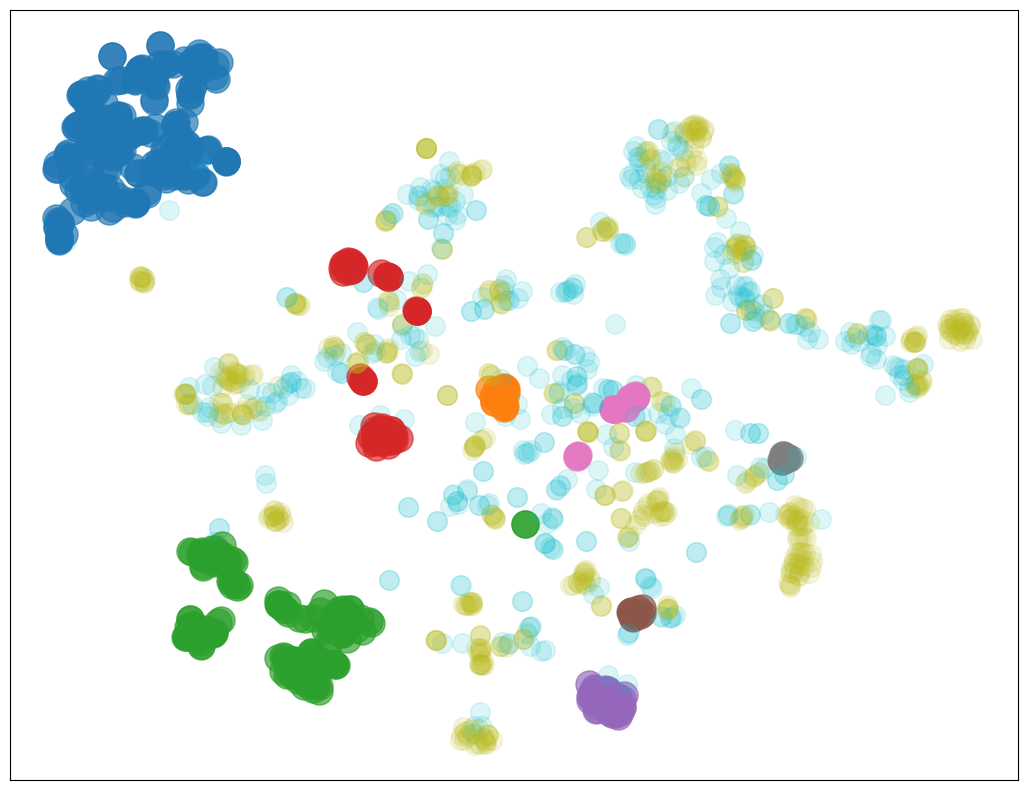

In [ ]:
embedded_points = tsne.fit_transform(PTR_dist + LoStOP_dist)
df_plot['x'] = embedded_points[:, 0]
df_plot['y'] = embedded_points[:, 1]

plt.figure(figsize=(13, 10))

for idx, row in df_plot.iterrows():
    if row['Final PTR'] == -1:
        alpha = 0.15  
        size = 200   
    elif row['group name'] == 'All other groups':
        alpha = 0.15  
        size = 200   
    else:
        alpha = 0.68  
        size = 380    

    plt.scatter(row['x'], row['y'], 
                color=row['color'], 
                label=row['group name'] if idx == 0 or row['group name'] not in df_plot.iloc[:idx]['group name'].tolist() else "",
                marker='o', 
                s=size, 
                alpha=alpha)

plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig.png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
df_plot.to_csv('tsne_plot.csv')

### Figure S2

c:\Users\shuyan.hao\anaconda3\envs\icet\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\shuyan.hao\anaconda3\envs\icet\lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\shuyan.hao\anaconda3\envs\icet\lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\shuyan.hao\anaconda3\envs\icet\lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._

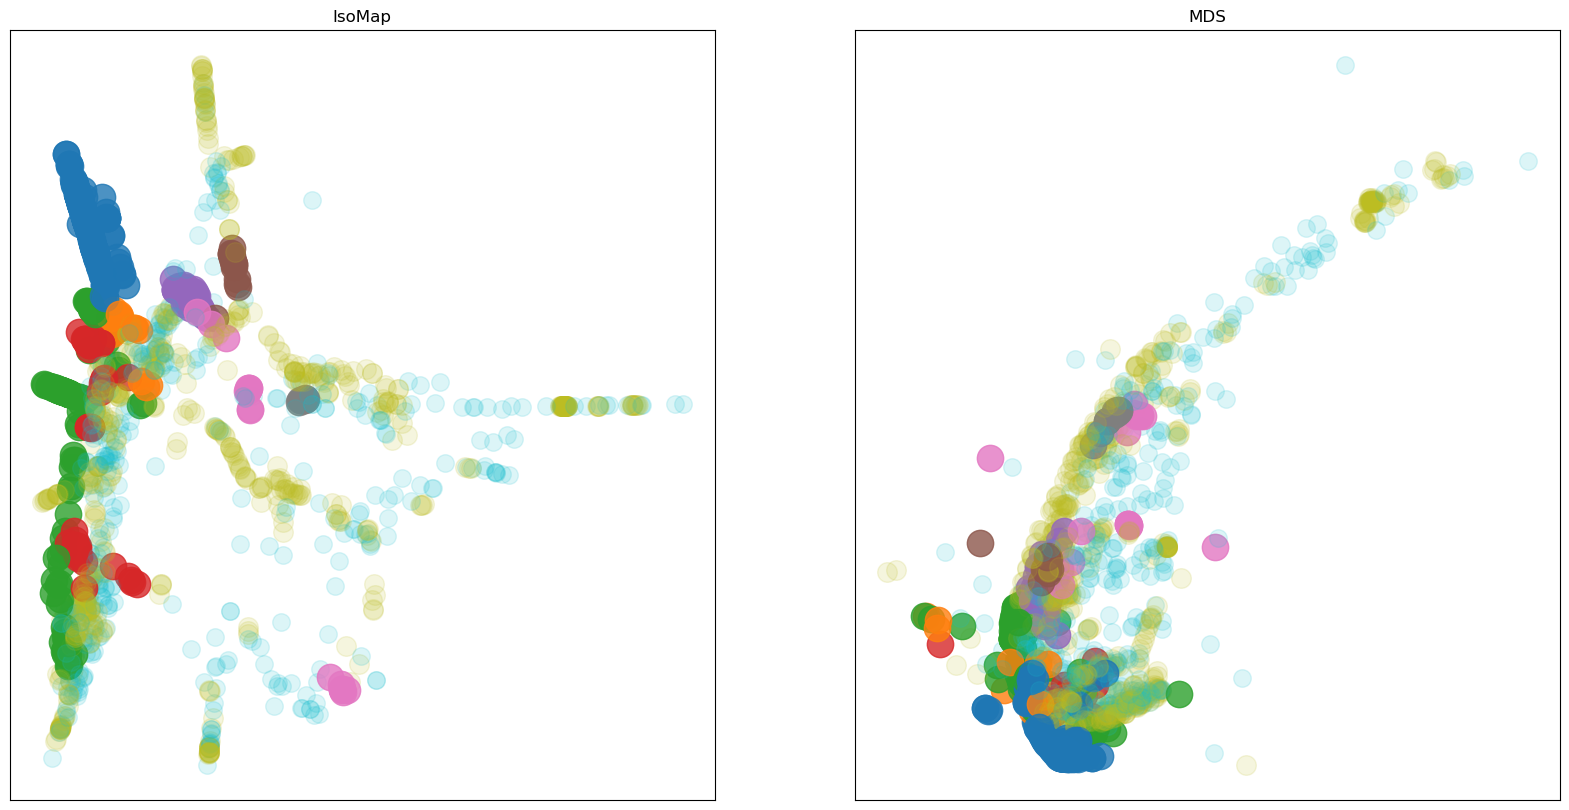

In [ ]:

isomap = Isomap(n_components=2)
isomap_results = isomap.fit_transform(df_dist)

mds = MDS(n_components=2)
mds_results = mds.fit_transform(df_dist)

plt.figure(figsize=(20, 10))

# IsoMap
plt.subplot(1, 2, 1)
for i, (idx, row) in enumerate(df_plot.iterrows()):  
    if row['Final PTR'] == -1:
        alpha = 0.15  
        size = 160    
    elif row['group name'] == 'All other groups':
        alpha = 0.15  
        size = 200    
    else:
        alpha = 0.8   
        size = 360   

    plt.scatter(isomap_results[i, 0], isomap_results[i, 1], color=row['color'], alpha=alpha, s=size) 

plt.title('IsoMap')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.xticks([])
plt.yticks([])

# MDS
plt.subplot(1, 2, 2)
for i, (idx, row) in enumerate(df_plot.iterrows()):  
    if row['Final PTR'] == -1:
        alpha = 0.15
        size = 160
    elif row['group name'] == 'All other groups':
        alpha = 0.15
        size = 200
    else:
        alpha = 0.8
        size = 360

    plt.scatter(mds_results[i, 0], mds_results[i, 1], color=row['color'], alpha=alpha, s=size)  

plt.title('MDS')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.xticks([])
plt.yticks([])
plt.savefig('compare.png', dpi=600, bbox_inches='tight')
plt.show()

### Figure S3

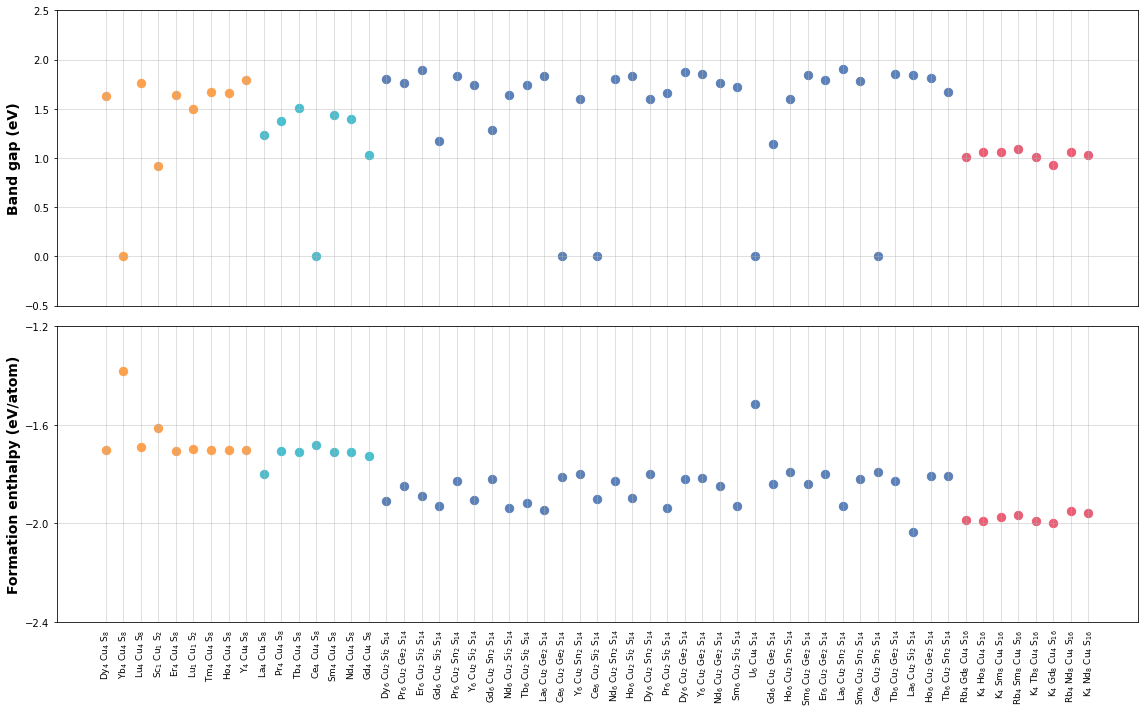

In [ ]:
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
colors = ['#FCA24F', '#4DBECE', '#5b81b8', '#ea5e76']

ax1.grid(True, linestyle='-', alpha=0.5)
ax2.grid(True, linestyle='-', alpha=0.5)

for index, label in enumerate([8, 17, 52, 76]):
    color = colors[index]
    ax1.scatter(groups[label]['x_range'], groups[label]['third_column'], color=color, s=70)
    ax2.scatter(groups[label]['x_range'], groups[label]['fourth_column'], color=color, s=70)

# set y scale
ax1.set_ylabel("Formation enthalpy (eV/atom)", fontsize=14, fontweight='bold')
ax1.set_ylim(-2.4, -1.2)
ax1.yaxis.set_major_locator(MultipleLocator(0.4))
ax1.tick_params(axis='both', which='both', labelsize=10)

ax2.set_ylabel("Band gap (eV)", fontsize=14, fontweight='bold')
ax2.set_ylim(-0.5, 2.5)

# set x labels
all_formulas = sum([group['formula'] for group in groups.values()], [])
plt.xticks(np.arange(len(all_formulas)) * 2, all_formulas, rotation=90, fontsize=9)

ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
plt.tight_layout()

plt.savefig('FigS3.png', dpi=600, bbox_inches='tight')
plt.show()